<a href="https://colab.research.google.com/github/gamyndiaye/gamyndiaye.github.io/blob/master/FinalProj_EAS644.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Synopsis:** Air pollution is monitored on state and federal levels using EPA sensors for pollutants like Ozone and Particulate Matter. Based on these data, a spatial representation of pollutants throughout the city can be determined. The objective and ultimate product of this project was to create an interactive map of California using ArcGIS to show where sensors are located throughout the city. To get the final maps, nearly all spatial tasks were automated through python. Manipulations of the data were conducted using dataframes through pandas. The os module allowed for us to create and manipulate folder pathways to output new features to. Overall, the final output of this project is a map showing the PM2.5 sensors in California as well as AQI data near those sensors.

Air pollution meteorology is the study of air pollutant dispersion and their effect on public health. A future goal for this project is using data visualization to understand and recognize patterns in air pollution locations to better streamline analysis of air quality problems. However, this would involve integrating meterology and topology into the analysis.

By: [Aminata Ndiaye](https://www.linkedin.com/in/amy-ndiaye-504an/) and [Haylee Miller](https://www.linkedin.com/in/haylee-miller/)


**Outputs**

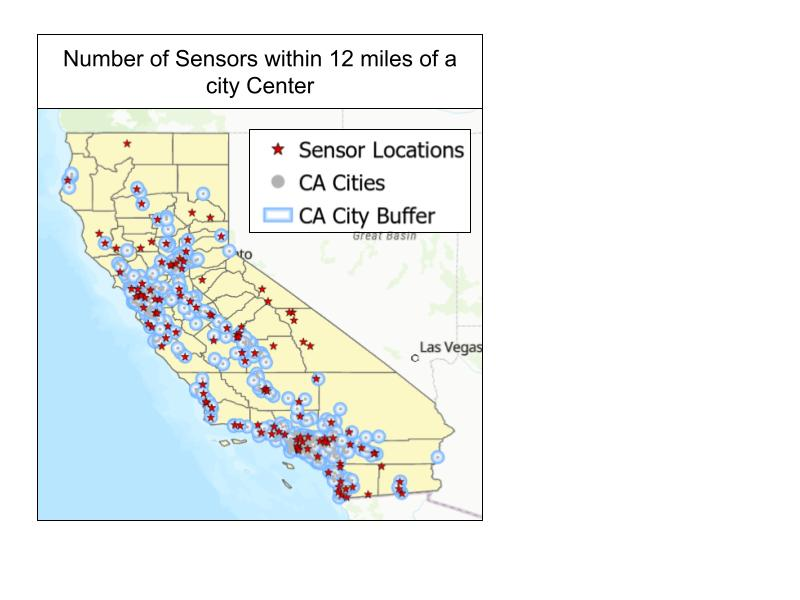

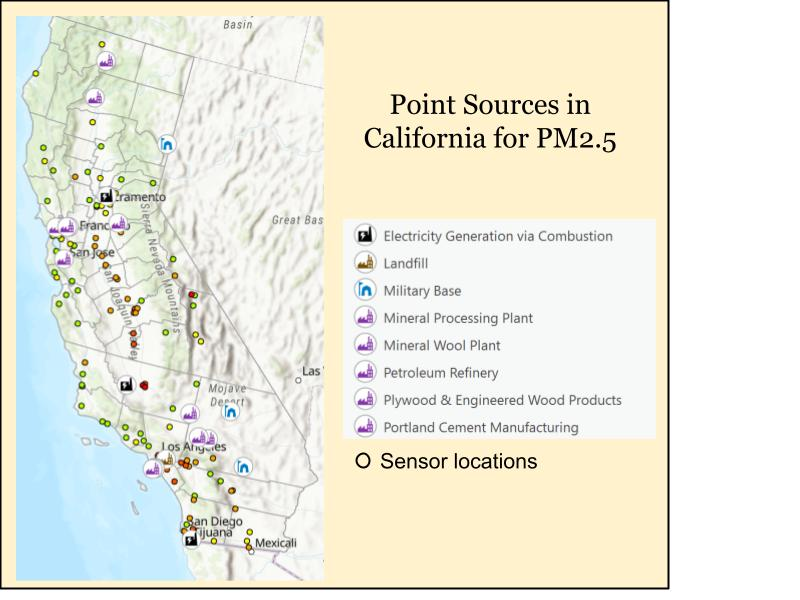

Timelapse of PM2.5 daily mean concentrations in California, 2022

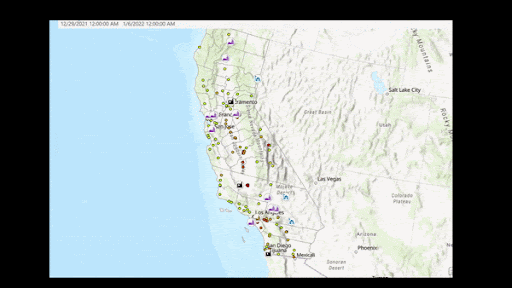

**CODE**

In [ ]:
import arcpy
import os
import pandas as pd

In [ ]:
#set workspace for file paths
arcpy.env.workspace = r"C:\Users\Hayle\Desktop\EAS 644"
arcpy.env.overwriteOutput = True
out_workspace = r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\EAS 644 Semester Project.gdb"

# Compile a list of feature layers we want to copy into the workspace
# Here we want the cities, counties, and states in the US
fc_list = [r"C:\Users\Hayle\Desktop\EAS 644\Usa\usdata.gdb\states",
           r"C:\Users\Hayle\Desktop\EAS 644\Usa\usdata.gdb\cities",
          r"C:\Users\Hayle\Desktop\EAS 644\Usa\usdata.gdb\counties"]

# Run CopyFeatures for each feature and copy into the workspace gdb to leave the original gdb undisturbed
for fc in fc_list:
    # Concatenate the file pathway to the workspace along with the name of the feature layer to create a new output
    out_featureclass = os.path.join(out_workspace,
                                    fc + "_copy") #this takes the original name and adds an "_copy" at the end
    arcpy.management.CopyFeatures(fc, out_featureclass)
    print(out_featureclass)


# Selecting all states but CA
statesToDelete = arcpy.management.SelectLayerByAttribute(
    in_layer_or_view="states_copy",
    selection_type="NEW_SELECTION",
    where_clause="STATE_NAME = 'California'",
    invert_where_clause= 'INVERT'
)

#Delete the selection (all states but CA) to leave CA
arcpy.management.DeleteFeatures(statesToDelete )

# Selecting all cities but our cities in CA
citiesToDelete = arcpy.management.SelectLayerByAttribute(
    in_layer_or_view="cities_copy",
    selection_type="NEW_SELECTION",
    where_clause="ST = 'CA'",
    invert_where_clause= 'INVERT')

#Deletes every city but CA cities
arcpy.management.DeleteFeatures(citiesToDelete )


# Selecting CA counties
countiesToDelete = arcpy.management.SelectLayerByAttribute(
    in_layer_or_view="counties_copy",
    selection_type="NEW_SELECTION",
    where_clause="STATE_NAME = 'California'",
    invert_where_clause= 'INVERT'
)

# deletes every county but those in CA
arcpy.management.DeleteFeatures(countiesToDelete )

print("Finished selecting california state and cities and county")




In [ ]:
# Import EPA Daily PM2.5 Data For California

#read in file
df = pd.read_csv(r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\daily_88101_2022.csv")

#check file data
print(df)
print(df.info())

# Filter data for California and create dataframe for CA data
cali_sensors = df[df['State Name'] == 'California']

#Create a new CSV file for CA particulate matter
cali_sensors.to_csv(r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\CA_PM.csv", index=False)

#imports EPA data using the latitude and longtitude coordinates in the csv table to place sensor locations on ma[]
# all data attached to the sensors is populated into an attribute table
arcpy.management.XYTableToPoint(
    in_table =
    r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\CA_PM.csv",
    out_feature_class = r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\EAS 644 Semester Project.gdb\CA_PM",
    x_field="longitude",
    y_field="latitude",
    z_field=None,
    coordinate_system =
    'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]];-400 -400 1000000000;-100000 10000;-100000 10000;8.98315284119521E-09;0.001;0.001;IsHighPrecision'
)



**FINAL CODE FOR ALL OF CALIFORNIA PM DATA BY SITE**

In [ ]:
#read in file
df = pd.read_csv(r"C:\Users\gandiaye\Downloads\2023-24 Classes\EAS 544\EAS_544_Final_Project\Los Angeles Air Quality\daily_88101_2022\daily_88101_2022.csv")

print(df)
print(df.info())

# Filter data for CA state
CA_state = df[df['State Code'] == '6']
print("created california state dataframe")

# Group data by Site Num
grouped_data = CA_state.groupby('Site Num')
print("grouped CA state data by stie")

# create dataframe to store final data table
LA_yrpm_df = pd.DataFrame(columns=['Site Num','Average PM Concentration 2022'])
print("created empty data from with columns")

# Iterate over each group (site)
dfs_to_concat = []
for site, data in grouped_data:
    # Calculate yearly average for each site
    avg_pm_site = data['Arithmetic Mean'].mean()
    print(f"Calculated average PM for site {site}")
    site_df = pd.DataFrame({'Site Num': [site], 'Average PM Concentration 2022': [avg_pm_site]})
    dfs_to_concat.append(site_df)

# Concatenate dataframes
CA_yrpm_df = pd.concat(dfs_to_concat, ignore_index=True)
print(CA_yrpm_df)

#merge wanter fields from origial CSV with calculated mean
CA_yrpm_df = pd.merge(CA_yrpm_df, CA_state[['Site Num', 'Local Site Name','Address','State Name','County Name','City Name','CBSA Name','State Code', 'County Code', 'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Units of Measure']].drop_duplicates(), on='Site Num', how='left')
print(CA_yrpm_df)

# Convert final data table to CSV
CA_yrpm_df.to_csv(r"C:\Users\gandiaye\Downloads\2023-24 Classes\EAS 544\EAS_544_Final_Project\Los Angeles Air Quality\CA_yrpm.csv", index=False)


#converting avg yr data sites to XY points
arcpy.management.XYTableToPoint(
    in_table=r"C:\Users\gandiaye\Downloads\2023-24 Classes\EAS 544\EAS_544_Final_Project\Los Angeles Air Quality\CA_yrpm.csv",
    out_feature_class=r"C:\Users\gandiaye\Downloads\2023-24 Classes\EAS 544\EAS_544_Final_Project\Los Angeles Air Quality\Los Angeles Air Quality.gdb\CA_yrpm_XYTableToPoint",
    x_field="Longitude",
    y_field="Latitude",
    z_field=None,
    coordinate_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]];-400 -400 1000000000;-100000 10000;-100000 10000;8.98315284119521E-09;0.001;0.001;IsHighPrecision'
)
print("avg yr data sites to XY points complete")

#interpolating between points to create a raster showing PM2.5 levels across CA
out_raster = arcpy.sa.Idw(
    in_point_features="CA_yrpm_XYTableToPoint",
    z_field="Average_PM_Concentration_2022",
    cell_size=0.00243539999999985,
    power=2,
    search_radius="VARIABLE 12",
    in_barrier_polyline_features=None
)
out_raster.save(r"C:\Users\gandiaye\Downloads\2023-24 Classes\EAS 544\EAS_544_Final_Project\Los Angeles Air Quality\Los Angeles Air Quality.gdb\Idw_CA_yrpm")
print("raster interpolation between data sites complete")


In [ ]:
# Importing and filtering EPA National Emissions Inventory Data (Point sources across the US for 2017) for top polluters in California

import pandas as pd

pointdf = pd.read_csv(r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\point_678910.csv")

#print(pointdf)
#print(pointdf.info())

Refined by state and by PM

# Filter data for California

caliP = pointdf[ (pointdf['state'] == 'CA') & (pointdf['pollutant_code'] == 'PM25-PRI') ]


# pulling out the top 30 highest polluting PM point sources
caliP_top30 = caliP.nlargest(30, 'total_emissions')

# list of point sources
print(caliP_top30['company_name'])

# Creates a workable CSV for importing into ArcGIS
caliP_top30.to_csv(r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\CaliP.csv", index=False)

# Importing data into ArcGIS
arcpy.management.XYTableToPoint(
    in_table =
    r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\CaliP.csv",
    out_feature_class = r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\EAS 644 Semester Project.gdb\CA_PointSources",
    x_field="site_longitude",
    y_field="site_latitude",
    z_field=None,
    coordinate_system =
    'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]];-400 -400 1000000000;-100000 10000;-100000 10000;8.98315284119521E-09;0.001;0.001;IsHighPrecision'
)


In [ ]:
# Daily US AQI data filtered for California

import pandas as pd

#read in file
df = pd.read_csv(r"C:\Users\Hayle\Desktop\EAS 644\EAS 644 Semester Project\daily_aqi_by_county_2022.csv")

df.columns = map(str.lower, df.columns)

print(df)
print(df.info())

# Filter data for LA County
calAQI = df[df['state name'] == 'California']
#conc_data = LA_county['Arithmetic Mean'] #find PM2.5 column
#date = LA_county['Date'] #find date column

print(calAQI)



In [ ]:
#Determine the numeber of sensors within 12 miles of a city center
arcpy.analysis.Buffer(
    in_features="cities_copy",
    out_feature_class="CA_cities_Buffer",
    buffer_distance_or_field="20000 Meters",
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="NONE",
    dissolve_field=None,
    method="PLANAR"
)

arcpy.analysis.SpatialJoin(
    target_features="CA_cities_Buffer",
    join_features="CA_yrpm_XYTableToPoint",
    out_feature_class=r"C:\Users\gandiaye\Downloads\2023-24 Classes\EAS 544\EAS_544_Final_Project\Los Angeles Air Quality\Los Angeles Air Quality.gdb\CACityBuffer_SpatialJoin",
    join_operation="JOIN_ONE_TO_ONE",
    join_type="KEEP_ALL",
    field_mapping='NAME "NAME" true true false 57 Text 0 0,First,#,CA City Buffer,NAME,0,57;CLASS "CLASS" true true false 36 Text 0 0,First,#,CA City Buffer,CLASS,0,36;ST "ST" true true false 2 Text 0 0,First,#,CA City Buffer,ST,0,2;STFIPS "STFIPS" true true false 2 Text 0 0,First,#,CA City Buffer,STFIPS,0,2;PLACEFIPS "PLACEFIPS" true true false 7 Text 0 0,First,#,CA City Buffer,PLACEFIPS,0,7;CAPITAL "CAPITAL" true true false 10 Text 0 0,First,#,CA City Buffer,CAPITAL,0,10;POP_CLASS "POP_CLASS" true true false 2 Short 0 0,First,#,CA City Buffer,POP_CLASS,-1,-1;POPULATION "POP2014" true true false 4 Long 0 0,First,#,CA City Buffer,POPULATION,-1,-1;POP2010 "POP2010" true true false 4 Long 0 0,First,#,CA City Buffer,POP2010,-1,-1;WHITE "WHITE" true true false 4 Long 0 0,First,#,CA City Buffer,WHITE,-1,-1;BLACK "BLACK" true true false 4 Long 0 0,First,#,CA City Buffer,BLACK,-1,-1;AMERI_ES "AMERI_ES" true true false 4 Long 0 0,First,#,CA City Buffer,AMERI_ES,-1,-1;ASIAN "ASIAN" true true false 4 Long 0 0,First,#,CA City Buffer,ASIAN,-1,-1;HAWN_PI "HAWN_PI" true true false 4 Long 0 0,First,#,CA City Buffer,HAWN_PI,-1,-1;HISPANIC "HISPANIC" true true false 4 Long 0 0,First,#,CA City Buffer,HISPANIC,-1,-1;OTHER "OTHER" true true false 4 Long 0 0,First,#,CA City Buffer,OTHER,-1,-1;MULT_RACE "MULT_RACE" true true false 4 Long 0 0,First,#,CA City Buffer,MULT_RACE,-1,-1;MALES "MALES" true true false 4 Long 0 0,First,#,CA City Buffer,MALES,-1,-1;FEMALES "FEMALES" true true false 4 Long 0 0,First,#,CA City Buffer,FEMALES,-1,-1;AGE_UNDER5 "AGE_UNDER5" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_UNDER5,-1,-1;AGE_5_9 "AGE_5_9" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_5_9,-1,-1;AGE_10_14 "AGE_10_14" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_10_14,-1,-1;AGE_15_19 "AGE_15_19" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_15_19,-1,-1;AGE_20_24 "AGE_20_24" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_20_24,-1,-1;AGE_25_34 "AGE_25_34" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_25_34,-1,-1;AGE_35_44 "AGE_35_44" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_35_44,-1,-1;AGE_45_54 "AGE_45_54" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_45_54,-1,-1;AGE_55_64 "AGE_55_64" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_55_64,-1,-1;AGE_65_74 "AGE_65_74" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_65_74,-1,-1;AGE_75_84 "AGE_75_84" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_75_84,-1,-1;AGE_85_UP "AGE_85_UP" true true false 4 Long 0 0,First,#,CA City Buffer,AGE_85_UP,-1,-1;MED_AGE "MED_AGE" true true false 8 Double 0 0,First,#,CA City Buffer,MED_AGE,-1,-1;MED_AGE_M "MED_AGE_M" true true false 8 Double 0 0,First,#,CA City Buffer,MED_AGE_M,-1,-1;MED_AGE_F "MED_AGE_F" true true false 8 Double 0 0,First,#,CA City Buffer,MED_AGE_F,-1,-1;HOUSEHOLDS "HOUSEHOLDS" true true false 4 Long 0 0,First,#,CA City Buffer,HOUSEHOLDS,-1,-1;AVE_HH_SZ "AVE_HH_SZ" true true false 8 Double 0 0,First,#,CA City Buffer,AVE_HH_SZ,-1,-1;HSEHLD_1_M "HSEHLD_1_M" true true false 4 Long 0 0,First,#,CA City Buffer,HSEHLD_1_M,-1,-1;HSEHLD_1_F "HSEHLD_1_F" true true false 4 Long 0 0,First,#,CA City Buffer,HSEHLD_1_F,-1,-1;MARHH_CHD "MARHH_CHD" true true false 4 Long 0 0,First,#,CA City Buffer,MARHH_CHD,-1,-1;MARHH_NO_C "MARHH_NO_C" true true false 4 Long 0 0,First,#,CA City Buffer,MARHH_NO_C,-1,-1;MHH_CHILD "MHH_CHILD" true true false 4 Long 0 0,First,#,CA City Buffer,MHH_CHILD,-1,-1;FHH_CHILD "FHH_CHILD" true true false 4 Long 0 0,First,#,CA City Buffer,FHH_CHILD,-1,-1;FAMILIES "FAMILIES" true true false 4 Long 0 0,First,#,CA City Buffer,FAMILIES,-1,-1;AVE_FAM_SZ "AVE_FAM_SZ" true true false 8 Double 0 0,First,#,CA City Buffer,AVE_FAM_SZ,-1,-1;HSE_UNITS "HSE_UNITS" true true false 4 Long 0 0,First,#,CA City Buffer,HSE_UNITS,-1,-1;VACANT "VACANT" true true false 4 Long 0 0,First,#,CA City Buffer,VACANT,-1,-1;OWNER_OCC "OWNER_OCC" true true false 4 Long 0 0,First,#,CA City Buffer,OWNER_OCC,-1,-1;RENTER_OCC "RENTER_OCC" true true false 4 Long 0 0,First,#,CA City Buffer,RENTER_OCC,-1,-1;BUFF_DIST "BUFF_DIST" true true false 8 Double 0 0,First,#,CA City Buffer,BUFF_DIST,-1,-1;ORIG_FID "ORIG_FID" true true false 4 Long 0 0,First,#,CA City Buffer,ORIG_FID,-1,-1;Shape_Length "Shape_Length" false true true 8 Double 0 0,First,#,CA City Buffer,Shape_Length,-1,-1;Shape_Area "Shape_Area" false true true 8 Double 0 0,First,#,CA City Buffer,Shape_Area,-1,-1;NAME_1 "NAME" true true false 57 Text 0 0,First,#,CA Cities,NAME,0,57;CLASS_1 "CLASS" true true false 36 Text 0 0,First,#,CA Cities,CLASS,0,36;ST_1 "ST" true true false 2 Text 0 0,First,#,CA Cities,ST,0,2;STFIPS_1 "STFIPS" true true false 2 Text 0 0,First,#,CA Cities,STFIPS,0,2;PLACEFIPS_1 "PLACEFIPS" true true false 7 Text 0 0,First,#,CA Cities,PLACEFIPS,0,7;CAPITAL_1 "CAPITAL" true true false 10 Text 0 0,First,#,CA Cities,CAPITAL,0,10;POP_CLASS_1 "POP_CLASS" true true false 2 Short 0 0,First,#,CA Cities,POP_CLASS,-1,-1;POPULATION_1 "POP2014" true true false 4 Long 0 0,First,#,CA Cities,POPULATION,-1,-1;POP2010_1 "POP2010" true true false 4 Long 0 0,First,#,CA Cities,POP2010,-1,-1;WHITE_1 "WHITE" true true false 4 Long 0 0,First,#,CA Cities,WHITE,-1,-1;BLACK_1 "BLACK" true true false 4 Long 0 0,First,#,CA Cities,BLACK,-1,-1;AMERI_ES_1 "AMERI_ES" true true false 4 Long 0 0,First,#,CA Cities,AMERI_ES,-1,-1;ASIAN_1 "ASIAN" true true false 4 Long 0 0,First,#,CA Cities,ASIAN,-1,-1;HAWN_PI_1 "HAWN_PI" true true false 4 Long 0 0,First,#,CA Cities,HAWN_PI,-1,-1;HISPANIC_1 "HISPANIC" true true false 4 Long 0 0,First,#,CA Cities,HISPANIC,-1,-1;OTHER_1 "OTHER" true true false 4 Long 0 0,First,#,CA Cities,OTHER,-1,-1;MULT_RACE_1 "MULT_RACE" true true false 4 Long 0 0,First,#,CA Cities,MULT_RACE,-1,-1;MALES_1 "MALES" true true false 4 Long 0 0,First,#,CA Cities,MALES,-1,-1;FEMALES_1 "FEMALES" true true false 4 Long 0 0,First,#,CA Cities,FEMALES,-1,-1;AGE_UNDER5_1 "AGE_UNDER5" true true false 4 Long 0 0,First,#,CA Cities,AGE_UNDER5,-1,-1;AGE_5_9_10 "AGE_5_9" true true false 4 Long 0 0,First,#,CA Cities,AGE_5_9,-1,-1;AGE_10_14_15 "AGE_10_14" true true false 4 Long 0 0,First,#,CA Cities,AGE_10_14,-1,-1;AGE_15_19_20 "AGE_15_19" true true false 4 Long 0 0,First,#,CA Cities,AGE_15_19,-1,-1;AGE_20_24_25 "AGE_20_24" true true false 4 Long 0 0,First,#,CA Cities,AGE_20_24,-1,-1;AGE_25_34_35 "AGE_25_34" true true false 4 Long 0 0,First,#,CA Cities,AGE_25_34,-1,-1;AGE_35_44_45 "AGE_35_44" true true false 4 Long 0 0,First,#,CA Cities,AGE_35_44,-1,-1;AGE_45_54_55 "AGE_45_54" true true false 4 Long 0 0,First,#,CA Cities,AGE_45_54,-1,-1;AGE_55_64_65 "AGE_55_64" true true false 4 Long 0 0,First,#,CA Cities,AGE_55_64,-1,-1;AGE_65_74_75 "AGE_65_74" true true false 4 Long 0 0,First,#,CA Cities,AGE_65_74,-1,-1;AGE_75_84_85 "AGE_75_84" true true false 4 Long 0 0,First,#,CA Cities,AGE_75_84,-1,-1;AGE_85_UP_1 "AGE_85_UP" true true false 4 Long 0 0,First,#,CA Cities,AGE_85_UP,-1,-1;MED_AGE_1 "MED_AGE" true true false 8 Double 0 0,First,#,CA Cities,MED_AGE,-1,-1;MED_AGE_M_1 "MED_AGE_M" true true false 8 Double 0 0,First,#,CA Cities,MED_AGE_M,-1,-1;MED_AGE_F_1 "MED_AGE_F" true true false 8 Double 0 0,First,#,CA Cities,MED_AGE_F,-1,-1;HOUSEHOLDS_1 "HOUSEHOLDS" true true false 4 Long 0 0,First,#,CA Cities,HOUSEHOLDS,-1,-1;AVE_HH_SZ_1 "AVE_HH_SZ" true true false 8 Double 0 0,First,#,CA Cities,AVE_HH_SZ,-1,-1;HSEHLD_1_M_1 "HSEHLD_1_M" true true false 4 Long 0 0,First,#,CA Cities,HSEHLD_1_M,-1,-1;HSEHLD_1_F_1 "HSEHLD_1_F" true true false 4 Long 0 0,First,#,CA Cities,HSEHLD_1_F,-1,-1;MARHH_CHD_1 "MARHH_CHD" true true false 4 Long 0 0,First,#,CA Cities,MARHH_CHD,-1,-1;MARHH_NO_C_1 "MARHH_NO_C" true true false 4 Long 0 0,First,#,CA Cities,MARHH_NO_C,-1,-1;MHH_CHILD_1 "MHH_CHILD" true true false 4 Long 0 0,First,#,CA Cities,MHH_CHILD,-1,-1;FHH_CHILD_1 "FHH_CHILD" true true false 4 Long 0 0,First,#,CA Cities,FHH_CHILD,-1,-1;FAMILIES_1 "FAMILIES" true true false 4 Long 0 0,First,#,CA Cities,FAMILIES,-1,-1;AVE_FAM_SZ_1 "AVE_FAM_SZ" true true false 8 Double 0 0,First,#,CA Cities,AVE_FAM_SZ,-1,-1;HSE_UNITS_1 "HSE_UNITS" true true false 4 Long 0 0,First,#,CA Cities,HSE_UNITS,-1,-1;VACANT_1 "VACANT" true true false 4 Long 0 0,First,#,CA Cities,VACANT,-1,-1;OWNER_OCC_1 "OWNER_OCC" true true false 4 Long 0 0,First,#,CA Cities,OWNER_OCC,-1,-1;RENTER_OCC_1 "RENTER_OCC" true true false 4 Long 0 0,First,#,CA Cities,RENTER_OCC,-1,-1',
    match_option="CONTAINS",
    search_radius="20000 Meters",
    distance_field_name=""
)

arcpy.management.FieldStatisticsToTable(
    in_table="CACityBuffer_SpatialJoin",
    in_fields="Join_Count",
    out_location=r"C:\Users\gandiaye\Downloads\2023-24 Classes\EAS 544\EAS_544_Final_Project\Los Angeles Air Quality\Los Angeles Air Quality.gdb",
    out_tables="ALL CA_City___Sensor_Buffer_FieldStatisticsToTable",
    group_by_field=None,
    out_statistics=None
)
